## Plotly  choropleth  from shapefiles 

In this notebook we define and plot comparatively the usual Plotly choropleth, and the Mapbox choropleth  from a shapefile.

To get the shapefile for the counties/regions of a country we access the Global Administrative Areas Database (GADM) https://gadm.org/, select Data, and then click the link country and choose from a dropdown menu the country of interest https://gadm.org/download_country_v3.html.

Each zip file downloaded from GADM contains multiple shapefiles, indexed by the level of detail, with 0, 1, 2, 3, eventually 4. Level 0 contains the shapefile of a country (UK, for example). Level 1 corresponds to provinces (regions) (in UK there exist four provinces: England, Scotland, Wales, and Northern Ireland. Level 2 shapefiles represent counties, and level 3, 4, smaller administrative subdivisions of each county.

There exist at least 4 files with the same level index. Their extension is shp, shx, dbf, prj. For more information on these files see https://en.wikipedia.org/wiki/Shapefile.

A shape file is read as a geopandas dataframe, by geopandas.read_file('filename.shp'), https://github.com/geopandas/geopandas/blob/fbe743f3131cc5942fef8362ef2aed606dc45e23/doc/source/io.rst

In this notebook we illustrate the two types of choropleths for  Germany states.

In [1]:
from chart_studio.plotly import iplot
import plotly.graph_objs as go
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
import pandas as pd
import numpy as np

Set the level index for the file to be read:

In [2]:
level = 1
gdf = gpd.read_file(f"DEU_shp/gadm36_DEU_{level}.shp", encoding='utf-8')
gdf.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,DEU,Germany,DEU.1_1,Baden-Württemberg,None,None,Land,State,08,DE.BW,"(POLYGON ((8.708021159999999 47.6895752, 8.707..."
1,DEU,Germany,DEU.2_1,Bayern,Bavaria,None,Freistaat,None,09,DE.BY,"POLYGON ((9.740663530000001 47.55353546, 9.740..."
2,DEU,Germany,DEU.3_1,Berlin,None,None,Land,State,11,DE.BE,"POLYGON ((13.17135715 52.3977623, 13.17135334 ..."
3,DEU,Germany,DEU.4_1,Brandenburg,None,None,Land,State,12,DE.BR,"(POLYGON ((12.26715565 52.2313118, 12.27047348..."
4,DEU,Germany,DEU.5_1,Bremen,None,None,Freie Hansestadt,State,04,DE.HB,"(POLYGON ((8.711423870000001 53.04463196, 8.71..."


In [3]:
geo_names=list(gdf[f'NAME_{level}'])
geo_names

['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

This map has a particularity, namely, the state Berlin, for example, is  an island within the state Brandenburg. 
In such a case the  shapefile geometry of the state Brandenburg has both exterior and interior boundary.
This explains our choice of using the boundary coordinates (i.e. both exterior and interior boundary of polygons), not only the exterione ones, as in `plotly.figure_factory.create_choropleth`, that was devised only for US county choropleths.

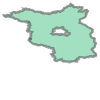

In [4]:
gdf['geometry'][3]# the state Brandenburg 

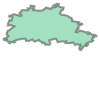

In [5]:
gdf['geometry'][2]# Berlin an "island" within the state Brandenburg, above

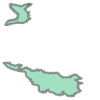

In [6]:
gdf['geometry'][4]# Bremen  state consists in two non-intersecting geometries (they are both surrounded by  Niedersachsen)

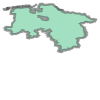

In [7]:
gdf['geometry'][8]# Niedersachsen

Read the pandas dataframe that contains a column with population value for each state:

In [8]:
df=pd.read_csv('https://raw.githubusercontent.com/empet/Datasets/master/Germany-pop.csv')
df

,state,population
0,Baden-Württemberg,10075500
1,Bayern,12542000
2,Berlin,3469000
3,Brandenburg,2500000
4,Bremen,661000
5,Hamburg,1788000
6,Hessen,6066000
7,Mecklenburg-Vorpommern,1639000
8,Niedersachsen,7914000
9,Nordrhein-Westfalen,17837000


Add a column `vals` to the `geopandas.DataFrame`, after you ensured that the state order is the same in both data frames:

In [9]:
gdf['vals']=list(df['population'])

Plotly colorscale  for coloring the  choropleth map:

In [10]:
pl_deep=[[0.0, 'rgb(253, 253, 204)'],
         [0.1, 'rgb(201, 235, 177)'],
         [0.2, 'rgb(145, 216, 163)'],
         [0.3, 'rgb(102, 194, 163)'],
         [0.4, 'rgb(81, 168, 162)'],
         [0.5, 'rgb(72, 141, 157)'],
         [0.6, 'rgb(64, 117, 152)'],
         [0.7, 'rgb(61, 90, 146)'],
         [0.8, 'rgb(65, 64, 123)'],
         [0.9, 'rgb(55, 44, 80)'],
         [1.0, 'rgb(39, 26, 44)']]


Function that maps a value, `val` in the interval, [vmin, vmax], to a color in the given colorscale:

In [11]:
from ast import literal_eval
def get_color_for_val(val, vmin, vmax, pl_colorscale):
    
    if pl_colorscale[0][1][:3] != 'rgb':
        raise ValueError('This function works only with Plotly type rgb-colorscales')
    if vmin >= vmax:
        raise ValueError('vmin should be < vmax')
    
        
    plotly_scale, plotly_colors = np.array(pl_colorscale)[:, 0].astype(float), \
                                  np.array(pl_colorscale)[:, 1] 
    colors_01 = np.array([literal_eval(color[3:]) for color in plotly_colors])/255.  #color codes in [0,1]
    
    v= (val - vmin) / float((vmax - vmin)) # val is mapped to v in [0,1]
    #find two consecutive values in plotly_scale such that   v is in  the corresponding interval
    idx = 0
   
    while(v > plotly_scale[idx+1]): 
        idx += 1
    left_scale_val = plotly_scale[idx]
    right_scale_val = plotly_scale[idx+ 1]
    vv = (v - left_scale_val) / (right_scale_val - left_scale_val)
    
    #get   [0,1]-valued color code representing the rgb color corresponding to val
    val_color01 = colors_01[idx] + vv * (colors_01[idx + 1] - colors_01[idx])
    val_color_0255 = (255*val_color01+0.5).astype(int)
    return f'rgb{str(tuple(val_color_0255))}'

The following function returns the list of traces for a choropleth, based on data recorded in the `geopandas.DataFrame`, `gdf`.

In [12]:
def get_choropleth_data(gdf, index_list, col_names= f'NAME_{level}', tolerance=0.025, col_vals='vals',
                        val_name='val', colorscale=pl_deep,   linewidth=0.75, 
                        linecolor= 'rgb(100, 100, 100)', colorbar=True):  
    # gdf - geopandas dataframe containing at least the geometry column and the column values to be mapped to a colorscale
    # index_list - a sublist of list(gdf.index) for the  geometries to be plotted; gdf.index for all data in gdf
    # col_names - string defining the gdf column  of county/region names
    # tolerance - float parameter to set the Polygon/MultiPolygon degree of simplification
    # col_vals - string that gives the gdf column name for values to be mapped to the colorscale
    # val_name - string to be displayed on hover above a centroid ; specifies what displayed value represent
    # colorscale - a  colorscale explicitly defined, not a Plotly coloscale name given as string, such as 'Viridis'
    # linecolor - color code for region/county boundary line
    # returns len(index_list) traces for filled regions, plus the centroids trace, and optionally a dummy trace for colorbar
    
    cdata = []
    x_centroids = []
    y_centroids = []
    centro_tooltip = []
    vmin, vmax = gdf[col_vals].min(),  gdf[col_vals].max()
    
    for index in index_list:
        geo = gdf['geometry'][index].simplify(tolerance)
        xb = []
        yb = []
        c_x, c_y = geo.centroid.xy
        if isinstance(geo.boundary, LineString):
            xc, yc = geo.boundary.coords.xy
            xb.extend(xc.tolist()+[None])
            yb.extend(yc.tolist()+ [None])
        elif  isinstance(geo.boundary, MultiLineString): 
            for b in geo.boundary:
                xc, yc = b.coords.xy
                xb.extend(xc.tolist()+[None])
                yb.extend(yc.tolist()+ [None])
        else:
            raise ValueError('Unknown boundary type')
            
        x_centroids.extend(list(c_x))
        y_centroids.extend(list(c_y))
       
        centro_tooltip.append(f"{gdf[col_names][index]}<br>{val_name}: {round(gdf['vals'][index], 2)}")
        color = get_color_for_val(gdf[col_vals][index], vmin, vmax, colorscale) 
       
        
        region = go.Scatter(# choropleth trace
                            showlegend = False,
                            mode='lines',
                            line = dict(color=linecolor, width=linewidth),
                            x=list(xb),
                            y=list(yb),
                            fill='toself',
                            fillcolor = color,
                            hoverinfo='none')
        
        cdata.append(region)
    #define the trace of state centers. Since we have to update the Brandenburg center position we cannot define
    #this trace as a go.Scatter instance because fig.data cannot be updated
    centroids = go.Scatter(
                     mode='markers',
                     showlegend=False,
                     text= centro_tooltip,
                     marker = dict(size=6, color='white', opacity=0),
                     x=x_centroids,
                     y=y_centroids,
                     hoverinfo='text')  
    if colorbar:
        dummy_tr = go.Scatter(
                        x=[xb[0], xb[0]],
                        y=[yb[0], yb[0]],
                        showlegend=False, 
                        mode='markers',
                        name='',
                        marker=dict(size=0, color=[vmin, vmax], colorscale=colorscale,
                                colorbar=dict(thickness=20, ticklen=4)),
                        hoverinfo='none')
    
        cdata.extend([centroids, dummy_tr]) 
    else:
        cdata.append(centroids)
    return cdata


In [13]:
data = get_choropleth_data(gdf, gdf.index, linecolor='rgb(100,100,100)', linewidth=1, 
                           colorscale=pl_deep, val_name='Population')
#move upward the point pointing the state Brandenburg, to be distinct from Berlin;
#the shapefile data recorded the Brandenburg state center inside the state Berlin

X, Y = list(data[16].x), list(data[16].y) # convert to list to be allowed some value updates
X[3], Y[3] = 13.2, 52.95

data[16].update(x=X, y=Y);

In [20]:
axis_style = dict(visible=False, showgrid=False)
layout = dict(title_text='Germany choropleth map from a shapefile',
              separators = '., ,',
              title_x=0.5,
              font=dict(family='Balto', size=14),
              hovermode = 'closest',
              xaxis = dict(axis_style), 
              yaxis = dict(axis_style),
              width = 550,
              height = 700,
              plot_bgcolor='#F3F6FA')

In [21]:
fig = go.Figure(data=data, layout=layout)
fig.show()

.